Імпорти

In [79]:
from datasets import load_dataset
from nltk.tokenize import WordPunctTokenizer
from collections import Counter

import torch                                                                      
import torch.nn as nn                                                             
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader

In [2]:
ds = load_dataset("sms_spam")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 5574
    })
})


Подивлюсь на вигляд даних в датасеті

In [3]:
print(ds['train']["sms"][:3])
print(ds['train']["label"][:3])

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n', 'Ok lar... Joking wif u oni...\n', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n"]
[0, 0, 1]


Розіб'ю датасет на тренувальну, валідаційну й тестову вибірки

In [4]:
split_ds = ds["train"].train_test_split(test_size=0.2, seed=42)

print(split_ds)

test_val = split_ds["test"].train_test_split(test_size=0.5, seed=42)

print(test_val)

# Об'єдную датасети в один
dataset = {
    "train" : split_ds["train"],
    "test": test_val["train"],
    "val": test_val["test"]
}

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 4459
    })
    test: Dataset({
        features: ['sms', 'label'],
        num_rows: 1115
    })
})
DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 557
    })
    test: Dataset({
        features: ['sms', 'label'],
        num_rows: 558
    })
})


Перевірю адекватність розбиття

In [ ]:
label_counts_train = Counter(dataset["train"]["label"])
label_counts_test = Counter(dataset["test"]["label"])
label_counts_val = Counter(dataset["val"]["label"])

print("Тренувальна:", label_counts_train, "тестова", label_counts_test, "валідаційна", label_counts_val)

Тренувальна: Counter({0: 3861, 1: 598}) тестова Counter({0: 479, 1: 78}) валідаційна Counter({0: 487, 1: 71})


Напишу функцію токенізації

In [67]:
tokenizer = WordPunctTokenizer()


def my_tokenize(sentence):
    return tokenizer.tokenize(sentence.rstrip().lower())

print(my_tokenize(dataset["train"]["sms"][0]))


['k', '..', 'then', 'come', 'wenever', 'u', 'lik', 'to', 'come', 'and', 'also', 'tel', 'vikky', 'to', 'come', 'by', 'getting', 'free', 'time', '..:-)']


Токенізую речення

In [65]:
train_data = []
test_data = []
val_data = []


for ds_type in ["train", "test", "val"]:

    for example in dataset[ds_type]:

        text = example["sms"]
        label = example["label"]
        tokenized_text = my_tokenize(text)
        
        if ds_type == "train":
            train_data.append((tokenized_text, label))
        elif ds_type == "test":
            test_data.append((tokenized_text, label))
        elif ds_type == "val":
            val_data.append((tokenized_text, label))
        else:
            raise ValueError(f"Unknown dataset type: {ds_type}")
    
print([text for text, label in train_data[:3]])

[['k', '..', 'then', 'come', 'wenever', 'u', 'lik', 'to', 'come', 'and', 'also', 'tel', 'vikky', 'to', 'come', 'by', 'getting', 'free', 'time', '..:-)'], [':-)', ':-)'], ['i', 'need', 'you', 'to', 'be', 'in', 'my', 'strong', 'arms', '...']]


Створю словник слів з смс

In [69]:
def build_vocab(sentences, min_freq=10, plot_hist=False):

    word_counter = Counter()

    for tokenized_sentence in sentences:
        for word_punkt in tokenized_sentence:
            word_counter[word_punkt] += 1
    
    if plot_hist: # Для вибору min_freq розгляну гістограму частот слів
        plt.figure(figsize=(10,4))
        freqs = list(word_counter.values())
        plt.xlim(0, 40)
        sns.histplot(freqs, bins=range(1, 41))
        plt.xlabel("Частота слова")
        plt.ylabel("Кількість слів")
        plt.title("Розподіл частот слів")
        plt.show()


    vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
    
    for char, cnt in word_counter.items():
        if cnt > min_freq:
            vocab.add(char)
    
    return vocab


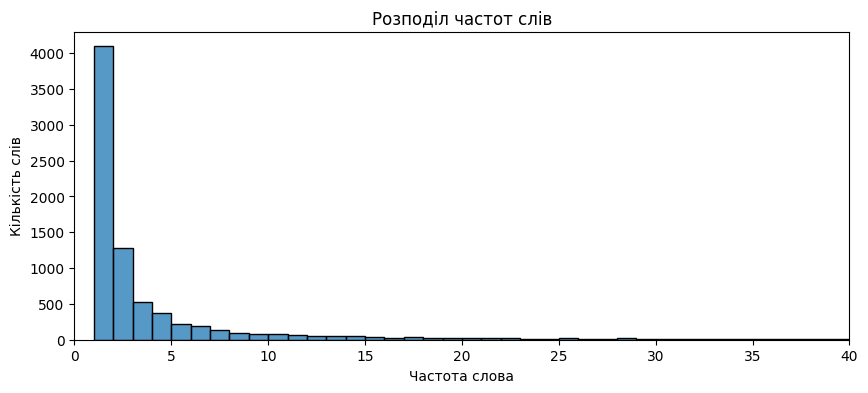

Кількість токенів у словнику:  2072


In [70]:
sentences = [text for text, label in train_data]

vocab = build_vocab(sentences, min_freq=3, plot_hist=True)
print("Кількість токенів у словнику: ", len(vocab))

In [72]:
word2ind = {token: i for i, token in enumerate(vocab)}
ind2word = {i: token for token, i in word2ind.items()}

Подивлюсь на гістограму розподілу довжин речень для вибору max_len

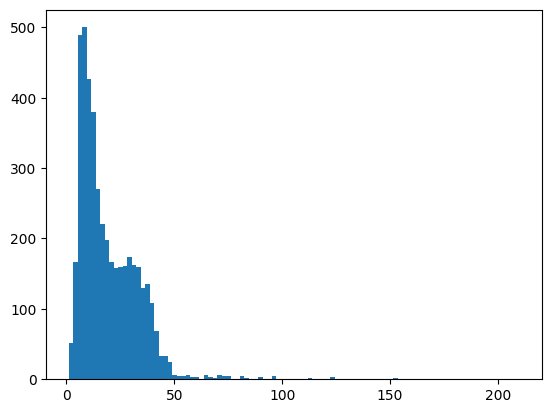

In [73]:
plt.hist([len(my_tokenize(x)) for x in dataset["train"]["sms"]], bins=100);

Напишу функцію collate(), яка буде приймати на вхід батч даних і повертати їх у вигляді, підходящому для передачі в мережу.

In [78]:
def collate_fn_with_padding(batch, max_len=50):

    texts, labels = map(list, zip(*batch))
    seq_lens = [len(x) for x in texts]
    max_seq_len = min(max(seq_lens), max_len)

    processed_texts = []
    
    for text, label in zip(texts, labels):
        text = text[:max_seq_len]
        text = [word2ind[x] if x in vocab else word2ind['<unk>'] for x in text]
        for _ in range(max_seq_len - len(text)):
            text.append(word2ind['<pad>'])

        processed_texts.append(text)
    
    processed_texts = torch.LongTensor(processed_texts)
    labels = torch.LongTensor(labels)

    processed_batch = {
        'input_ids': processed_texts,
        'label': labels
    }

    return processed_batch


Даталоадери

In [80]:
batch_size = 128

train_dataloader = DataLoader(
    train_data, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

val_dataloader = DataLoader(
    val_data, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_data, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)


Нейронка

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(
        self, hidden_dim, vocab_size, num_classes,
        aggregation_type: str = 'mean'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)

        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type


    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)          # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]         #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)           #[batch_size, hidden_dim]
        elif self.aggregation_type == 'last':
            output = output[:, -1, :]
        else:
            raise ValueError("Invalid aggregation_type")

        output = F.tanh(output)
        output = F.tanh(self.dropout(self.fc1(output)))   # [batch_size, hidden_dim]
        output = self.fc2(output)                         # [batch_size, num_classes]

        return output

In [83]:
def evaluate(model, dataloader):
    """
    Calculate accuracy on data from dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in (dataloader):
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [85]:
def train(model, optimizer, criterion, num_epoch=5, eval_steps=100):

    losses = []
    accs_train = []
    accs_val = []

    for epoch in range(num_epoch):
        print("епоха: ", epoch)
        epoch_losses = []
        model.train()
        for i, batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                accs_train.append(evaluate(model, train_dataloader))
                accs_val.append(evaluate(model, val_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    return losses, accs_train, accs_val

In [91]:
num_epoch = 10
eval_steps = len(train_dataloader) // 2


losses_type = {}
accs_train_type = {}
accs_val_type = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = SimpleRNN(hidden_dim=256,
                      vocab_size=len(vocab),
                      num_classes=2,
                      aggregation_type=aggregation_type
                      )
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    losses, accs_train, accs_val = train(model,
                                         optimizer,
                                         criterion,
                                         num_epoch=num_epoch,
                                         eval_steps=len(train_dataloader) // 2)

    losses_type[aggregation_type] = losses
    accs_train_type[aggregation_type] = accs_train
    accs_val_type[aggregation_type] = accs_val

Starting training for mean
епоха:  0
епоха:  1
епоха:  2
епоха:  3
епоха:  4
епоха:  5
епоха:  6
епоха:  7
епоха:  8
епоха:  9


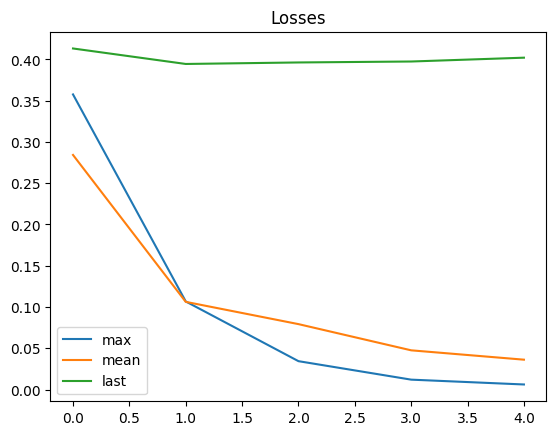

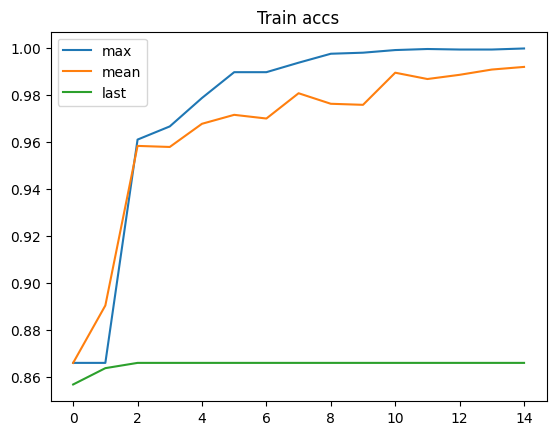

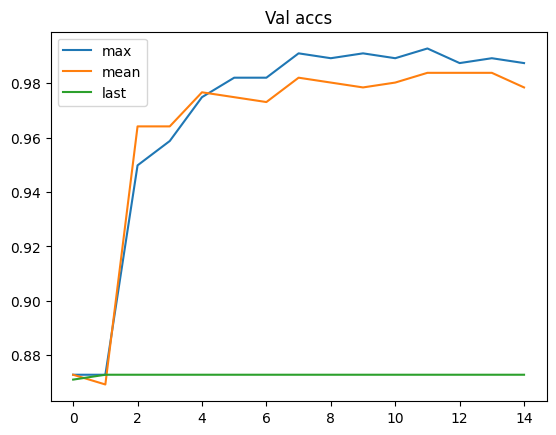

In [88]:
for aggregation_type in ['max', 'mean', 'last']:
    plt.plot(losses_type[aggregation_type])
plt.title('Losses')
plt.legend(['max', 'mean', 'last'])
plt.show()

for aggregation_type in ['max', 'mean', 'last']:
    plt.plot(accs_train_type[aggregation_type])
plt.title('Train accs')
plt.legend(['max', 'mean', 'last'])
plt.show()

for aggregation_type in ['max', 'mean', 'last']:
    plt.plot(accs_val_type[aggregation_type])
plt.title('Val accs')
plt.legend(['max', 'mean', 'last'])
plt.show()

In [93]:
print(evaluate(model, test_dataloader))

0.9874326586723328
